# Simulation of a Federated KMeans using scikit Learn and Federated Averaging

The purpose of this notebook is to test a KMeans algorithm in a federated setting.

Clustering data will be generated iusing `make_blob` function

In [1]:
from typing import List, Dict, Tuple

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin, pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.datasets import make_blobs

## Dataset generation

 1. Problem 1
 


In [3]:
# dataset parameters
SEED = 1234
np.random.seed(SEED)


## parameters for data generation
cluster_centers = [[1, 1], [-1, -1], [1, -1], [0, 1]]
n_samples = 200
cluster_std = .9
space_dim = 2

## algorithm parameters
batch_size = 20
n_init = 10  # nb of random initialization
n_clusters = 4
n_epochs = 10
## nodes parameters (for federated learning only)

nodes_id = ["alice", "bob", "charlie", "danny"]
n_rounds = 200
distance_metric = "euclidean"
nb_samples_per_nodes = [1, 1, 1, 1] # indicates how to sample data per node

In [4]:
# generate dataset


X, labels_true = make_blobs(n_samples=n_samples, centers=cluster_centers, cluster_std=cluster_std)

In [23]:
# comparing fit and partial fit methods

# train kmeans on local dataset
mbk_test1 = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size,
                              n_init=10, max_no_improvement=10, verbose=10, random_state=SEED)


for i, epoch in enumerate(range(n_epochs)):
    mbk_test1.partial_fit(X[i*batch_size: (i+1)* batch_size]) 

if (i+1)* batch_size < X.shape[0]:
    mbk_test1.partial_fit(X[(i+1)* batch_size :])

In [29]:
mbk_test1 = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size,
                              n_init=10, max_no_improvement=10, verbose=10, random_state=SEED)
mbk_test1.partial_fit(X[i*batch_size: (i+1)* batch_size]) 

MiniBatchKMeans(batch_size=20, n_clusters=4, n_init=10, random_state=1234,
                verbose=10)

In [30]:
mbk_test1.cluster_centers_

array([[ 0.83520231,  1.95307227],
       [-0.29771291, -1.03736104],
       [ 1.4764815 ,  0.82398436],
       [-1.29814127,  0.57345559]])

In [31]:
mbk_test2 = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size,
                              n_init=10, max_no_improvement=10, verbose=10, random_state=SEED)

mbk_test2.fit(X[i*batch_size: (i+1)* batch_size])

Init 1/10 with method: k-means++
Inertia for init 1/10: 9.998059
Init 2/10 with method: k-means++
Inertia for init 2/10: 10.184393
Init 3/10 with method: k-means++
Inertia for init 3/10: 14.411028
Init 4/10 with method: k-means++
Inertia for init 4/10: 9.120219
Init 5/10 with method: k-means++
Inertia for init 5/10: 10.039942
Init 6/10 with method: k-means++
Inertia for init 6/10: 11.238329
Init 7/10 with method: k-means++
Inertia for init 7/10: 9.697228
Init 8/10 with method: k-means++
Inertia for init 8/10: 9.120219
Init 9/10 with method: k-means++
Inertia for init 9/10: 9.120219
Init 10/10 with method: k-means++
Inertia for init 10/10: 10.493658
Minibatch iteration 1/100: mean batch inertia: 1.032831, ewa inertia: 1.032831 
Minibatch iteration 2/100: mean batch inertia: 0.722445, ewa inertia: 0.722445 
Minibatch iteration 3/100: mean batch inertia: 0.616567, ewa inertia: 0.616567 
Minibatch iteration 4/100: mean batch inertia: 0.457784, ewa inertia: 0.457784 
Minibatch iteration 5/1

MiniBatchKMeans(batch_size=20, n_clusters=4, n_init=10, random_state=1234,
                verbose=10)

In [34]:
mbk_test2.cluster_centers_ , mbk_test1.cluster_centers_

(array([[-0.01022003, -0.16411766],
        [ 1.41236591,  0.98748447],
        [-1.73155895, -0.69564556],
        [-0.19827704, -2.3535219 ]]),
 array([[ 0.83520231,  1.95307227],
        [-0.29771291, -1.03736104],
        [ 1.4764815 ,  0.82398436],
        [-1.29814127,  0.57345559]]))

## training on local dataset

Th goal of this sub section is to compare performance of K means on local dataset and on the same dataset but split among clients. 

Here we will train a k mean on local dataset, using `partial_fit` (performing one update using one batch size).

We iterate over partial fit to perfrom a complete epoch.

In [5]:
# train kmeans on local dataset
mbk_local = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size,
                              n_init=10, max_no_improvement=10, verbose=0, random_state=SEED)

history_local = {"euclidian": [], "obj": [], "db": []}
for r in range(n_rounds):
    for epoch in range(n_epochs):
        mbk_local.partial_fit(X) 

        
        history_local["obj"].append(mbk_local.score(X))
        order = pairwise_distances_argmin(cluster_centers,
                                  mbk_local.cluster_centers_,
                                     metric=distance_metric)
        euclidian_dist = np.sum(np.square(mbk_local.cluster_centers_[order] - cluster_centers), axis=1)

        history_local["euclidian"].append(np.sqrt(euclidian_dist).tolist())
        predicted = mbk_local.predict(X)
        db_score = davies_bouldin_score(X, predicted)
        history_local["db"].append(db_score)

### displaying local mini batch results & losses plots

Text(0.5, 0, 'epochs x rounds')

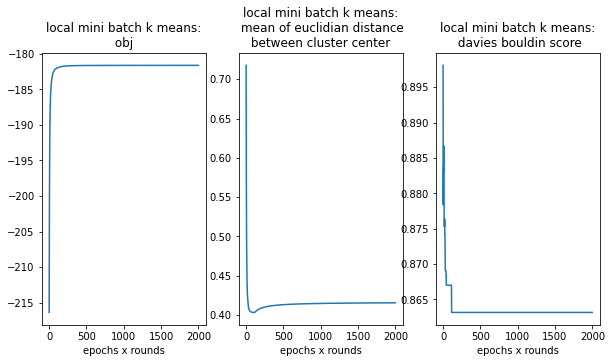

In [153]:
plt.figure(figsize=(10,5))
plt.subplot(1,3, 1)
plt.title("local mini batch k means:\n obj ")
plt.plot(history_local["obj"])
plt.xlabel("epochs x rounds")

plt.subplot(1,3,2)
plt.title("local mini batch k means:\n mean of euclidian distance\n between cluster center ")
plt.plot(np.mean(history_local["euclidian"], axis=1))
plt.xlabel("epochs x rounds")


plt.subplot(1,3,3)

plt.title("local mini batch k means:\n davies bouldin score")
plt.plot(history_local["db"])
plt.xlabel("epochs x rounds")

Mini batch k mean inertia:  181.62047088449808


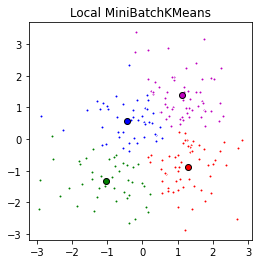

In [154]:
# plot results

mbk_means_cluster_centers = mbk_local.cluster_centers_
mbk_means_labels = mbk_local.predict(X)
colors = ['r', 'b', 'g', 'm']

fig = plt.figure(figsize=(4, 4))


for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
plt.title('Local MiniBatchKMeans')
print("Mini batch k mean inertia: ", mbk_local.inertia_)

## KMeans in a federated environment

### 1. split data into different nodes

In [116]:
labels_true[labels_true == 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [58]:
def generate_federated_clustering_dataset(dataset: np.ndarray,
                                          labels: np.ndarray,
                                          nodes_id: List[str],
                                          nb_samples_per_nodes: list,
                                          nb_samples: int=None,
                                         random_seed:int=None) -> Tuple[Dict[str, np.ndarray],
                                                                        Dict[str, np.ndarray]]:
    
    nb_samples_per_nodes = np.array(nb_samples_per_nodes)
    w_sum_nodes = nb_samples_per_nodes / nb_samples_per_nodes.sum()
    if nb_samples is None:
        nb_samples = nb_samples_per_nodes.sum()
    w_sum_nodes *= nb_samples
    
    print(w_sum_nodes)
    # make sure same amount of labels is present in each client
        
    all_X, all_labels = {}, {}
    labels_tags = np.unique(labels)
    n_labels = len(labels_tags)
    print(n_labels)
    
    idx_pointer = np.zeros((n_labels,2))
    
    for i,idx in enumerate(w_sum_nodes):
        # iterates over node"
        for i_lab, lab in enumerate(labels_tags):
            label_idx = lab == labels
            print(nodes_id[i])
            idx1 = int(idx_pointer[i_lab, 0])
            idx2 = idx1 + int(np.floor(idx / n_labels))
            print(idx1, idx2)
            #idx1_sample, idx2_sample = int(np.floor(idx / n_labels)), int(np.floor(idx / n_labels))
            sampled_X, sampled_labels = (dataset[label_idx][idx1: idx2],
                                            labels[label_idx][idx1: idx2])
            if nodes_id[i] not in all_X.keys():
                all_X[nodes_id[i]] = sampled_X
                all_labels[nodes_id[i]] = sampled_labels
            else:
                all_X[nodes_id[i]] = np.concatenate([all_X[nodes_id[i]], sampled_X], axis=0)
                all_labels[nodes_id[i]] = np.concatenate([all_labels[nodes_id[i]], sampled_labels], axis=0)
            idx1 = idx2
            idx_pointer[i_lab, 0] = idx1
        print("labels", all_labels[nodes_id[i]].shape , idx)
        
    for i,idx in enumerate(w_sum_nodes):
        if all_labels[nodes_id[i]].shape[0] < idx:
            diff = idx - all_labels[nodes_id[i]].shape[0]
           
        # complete here federated dataset with remaining data
            while diff > 0 :
                for i_lab, lab in enumerate(labels_tags):
                
                    label_idx = lab == labels
                    idx1 = int(idx_pointer[i_lab, 0])
                    #maximum = int(np.ceil(labels[label_idx].shape[0] / len(nodes_id)))
                    maximum = int(labels[label_idx].shape[0])
                    print("diffi",idx1, idx , labels[label_idx].shape[0],
                          diff, "max",maximum )
                    
                    #if idx1 < maximum * (i+1) :
                    if idx1  < maximum :
                        
                        print(all_X[nodes_id[i]], dataset[label_idx][idx1])
                        all_X[nodes_id[i]] = np.concatenate([all_X[nodes_id[i]],
                                                             dataset[label_idx][idx1].reshape(1,-1)],
                                                            axis=0)
                        print(all_labels[nodes_id[i]],
                                                                  labels[label_idx][idx1])
                        all_labels[nodes_id[i]] = np.concatenate([all_labels[nodes_id[i]],
                                                                  np.array([labels[label_idx][idx1]])], axis=0)
                        diff -= 1
                        idx1 += 1
                        idx_pointer[i_lab, 0] = idx1
                        if diff == 0:
                            break
                    else:
                        continue
                print("ERROR")
                #break
        print(idx_pointer)
        # randomly permute index of dataset of each node
        if random_seed is not None:
            rng = np.random.RandomState(random_seed)
            permuted_idx = rng.permutation(all_labels[nodes_id[i]].shape[0])
            all_X[nodes_id[i]]  = all_X[nodes_id[i]] [permuted_idx]
            all_labels[nodes_id[i]] = all_labels[nodes_id[i]][permuted_idx]
    return all_X, all_labels

In [77]:
federated_dataset, federated_labels = generate_federated_clustering_dataset(X,
                                                                            labels_true,
                                                                            nodes_id,
                                                                            nb_samples_per_nodes,
                                                                            n_samples,
                                                                           random_seed=12)

[50. 50. 50. 50.]
4
alice
0 12
alice
0 12
alice
0 12
alice
0 12
labels (48,) 50.0
bob
12 24
bob
12 24
bob
12 24
bob
12 24
labels (48,) 50.0
charlie
24 36
charlie
24 36
charlie
24 36
charlie
24 36
labels (48,) 50.0
danny
36 48
danny
36 48
danny
36 48
danny
36 48
labels (48,) 50.0
diffi 48 50.0 50 2.0 max 50
[[ 1.41795309 -2.20716499]
 [ 0.87688465  1.01646027]
 [ 0.29310831  1.41585376]
 [ 1.50916448  2.39109292]
 [ 1.01412673 -1.01841646]
 [ 1.3186183   0.96803828]
 [ 1.75690792 -0.30122907]
 [ 1.20426629 -0.0373932 ]
 [ 0.35147014  1.79844665]
 [ 0.5065818   0.86984244]
 [ 1.6338054   1.47115717]
 [ 1.03252774 -0.86747984]
 [-1.22358885 -1.55593598]
 [-1.28818349 -1.82457898]
 [-0.51689456 -1.66944733]
 [-0.81154469 -1.5335974 ]
 [-2.32580477 -1.80692255]
 [-0.21207205 -2.53964379]
 [-2.91125822 -1.3001522 ]
 [-2.26848857  0.28068736]
 [-2.87673908  0.73722209]
 [-1.10955557  1.12919177]
 [-2.07597137 -1.53267668]
 [ 0.10211692 -2.15299745]
 [ 0.20705762 -0.73442804]
 [ 1.26916348 -0.

In [24]:
labels_true[labels_true == 0].shape

(50,)

In [78]:
federated_dataset, federated_labels

({'alice': array([[ 0.75101849,  0.73207999],
         [ 0.16350547,  1.24704331],
         [ 1.20426629, -0.0373932 ],
         [-1.29291654,  1.18964535],
         [ 0.23808066,  1.50909251],
         [-1.15775358,  0.38692698],
         [-1.10955557,  1.12919177],
         [ 1.77734556,  0.89011758],
         [-2.26848857,  0.28068736],
         [ 0.35147014,  1.79844665],
         [-0.21207205, -2.53964379],
         [-0.68027596,  0.20699944],
         [ 0.47434181,  1.64000116],
         [-0.81154469, -1.5335974 ],
         [ 0.52783539, -0.93530976],
         [-0.51689456, -1.66944733],
         [ 0.55856477, -1.33699294],
         [ 0.5065818 ,  0.86984244],
         [ 1.02120185, -1.59420655],
         [ 0.89639367,  1.86000214],
         [-2.87673908,  0.73722209],
         [-2.32580477, -1.80692255],
         [ 0.20705762, -0.73442804],
         [ 0.35450304,  0.14497702],
         [ 1.52296599,  1.48745967],
         [ 1.93955019,  0.89700664],
         [ 0.10211692, -2.152

In [76]:
federated_labels["bob"].shape

(50,)

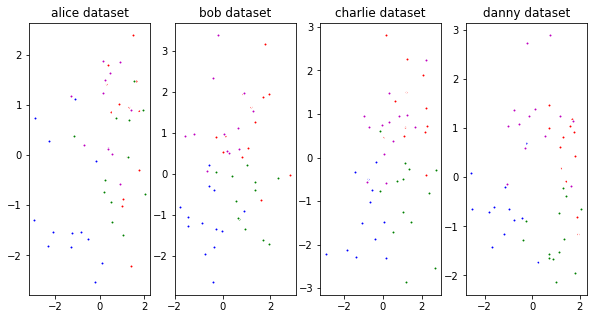

In [79]:
plt.figure(figsize=(10, 5))
n_clients = len(nodes_id)
for n_cli, cli in enumerate(nodes_id):
    plt.subplot(1, n_clients, n_cli+1)
    for k, col in zip(range(n_clusters), colors):
        my_members = federated_labels[cli] == k
        
        plt.plot(federated_dataset[cli][my_members, 0], federated_dataset[cli][my_members, 1], 'w',
                markerfacecolor=col, marker='.')
        plt.title(f"{cli} dataset")
        

### 2. Create different nodes

In [80]:
# create several nodes (as many as in nodes_id)

nodes = {}

for n in nodes_id:
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size,
                              n_init=10, max_no_improvement=10, verbose=0, random_state=SEED)
    nodes[n] = {'model' : mbk}

training:


In [81]:
history = {"obj": [], 'db':[], 'euclidian': []}

# initialisation: compute dataset weigths
w_sum = 0
for n in nodes.keys():
    nodes[n]['weigths'] = federated_dataset[n].shape[0]
w_sum +=  nodes[n]['weigths']
for n in nodes.keys():
    nodes[n]['weigths'] /= w_sum

In [82]:
nodes

{'alice': {'model': MiniBatchKMeans(batch_size=20, n_clusters=4, n_init=10, random_state=1234),
  'weigths': 1.0},
 'bob': {'model': MiniBatchKMeans(batch_size=20, n_clusters=4, n_init=10, random_state=1234),
  'weigths': 1.0},
 'charlie': {'model': MiniBatchKMeans(batch_size=20, n_clusters=4, n_init=10, random_state=1234),
  'weigths': 1.0},
 'danny': {'model': MiniBatchKMeans(batch_size=20, n_clusters=4, n_init=10, random_state=1234),
  'weigths': 1.0}}

there is a issue in the code : cluster distance are supposed to be unique: 

In [83]:


# federated training
for r in range(n_rounds):
    for n in nodes_id:
        for epoch in range(n_epochs):
            nodes[n]['model'].partial_fit(federated_dataset[n]) 
    
    # fedavg aggregating
        
    
            print(n, nodes[n]['model'].cluster_centers_)
    cluster_w = np.zeros((n_clusters, space_dim)).copy()
    #cluster_w = np.zeros((n_clusters, dim))
    order_memory = {}
    for i, n in enumerate(nodes_id):
        ref_order_model = nodes[nodes_id
                                [0]]['model']
        if len(nodes_id) > 1:
            comp_model = nodes[n]['model']
            order = pairwise_distances_argmin(ref_order_model.cluster_centers_,
                                              comp_model.cluster_centers_,
                                                 metric=distance_metric)
            
        else:
            order = np.arange(n_clusters)  # special case where only one node is considered
        order_memory[n] = order
        print(order)
        for c in range(n_clusters):
        
            if i == 0:
                
                cluster_w[c] += ref_order_model.cluster_centers_[c]* nodes[n]['weigths']
            else:
                cluster_w[c] += nodes[n]['model'].cluster_centers_[order][c] * nodes[n]['weigths']
            
    for c in range(n_clusters):        
        cluster_w[c] = cluster_w[c]/len(nodes_id)
        pass
        #cluster_w = cluster_w[order]
        #nodes[n]['model'].cluster_centers_ = cluster_w.copy()
    # update 
    for n in nodes_id:
        nodes[n]['model'].cluster_centers_ = cluster_w.copy()[order]
        print(n, nodes[n]['model'].cluster_centers_, '\n', cluster_w)
        # update history (predict on global dataset)
    predicted = nodes[n]['model'].predict(X)
    history["obj"].append(nodes[n]['model'].score(X))
    
    if len(np.unique(predicted)) == 1:
        db_score = 0
    else:
        db_score = davies_bouldin_score(X,predicted)
    history["db"].append(db_score)
    order = pairwise_distances_argmin(cluster_centers,
                                  nodes[n]['model'].cluster_centers_,
                                     metric=distance_metric)
    euclidian_dist = np.sum(np.square(nodes[n]['model'].cluster_centers_[order] - cluster_centers), axis=1)
    history["euclidian"].append(np.sqrt(euclidian_dist).tolist())
          

alice [[ 1.00533971 -0.28926264]
 [-1.25146679 -1.76843915]
 [ 0.72090485  1.48638985]
 [-1.56428822  0.65511216]]
alice [[ 0.93479756 -0.43827805]
 [-1.25146679 -1.76843915]
 [ 0.855528    1.38746529]
 [-1.56428822  0.65511216]]
alice [[ 0.90708458 -0.49681982]
 [-1.25146679 -1.76843915]
 [ 0.89124435  1.36122   ]
 [-1.56428822  0.65511216]]
alice [[ 0.89227901 -0.52809556]
 [-1.25146679 -1.76843915]
 [ 0.90776983  1.34907666]
 [-1.56428822  0.65511216]]
alice [[ 0.88306666 -0.54755602]
 [-1.25146679 -1.76843915]
 [ 0.91729628  1.34207638]
 [-1.56428822  0.65511216]]
alice [[ 0.8767816  -0.56083278]
 [-1.25146679 -1.76843915]
 [ 0.92349309  1.3375228 ]
 [-1.56428822  0.65511216]]
alice [[ 0.87221986 -0.57046914]
 [-1.25146679 -1.76843915]
 [ 0.92784623  1.334324  ]
 [-1.56428822  0.65511216]]
alice [[ 0.86875811 -0.57778184]
 [-1.25146679 -1.76843915]
 [ 0.93107194  1.33195367]
 [-1.56428822  0.65511216]]
alice [[ 0.8660413  -0.58352092]
 [-1.25146679 -1.76843915]
 [ 0.93355799  1.330

alice [[ 1.16064274  1.37219112]
 [-1.05805328 -1.33147392]
 [ 1.2464967  -0.87667076]
 [-0.50552148  0.72789169]]
alice [[ 1.157732    1.37125164]
 [-1.06156989 -1.33941875]
 [ 1.24189865 -0.87494288]
 [-0.51258136  0.72403882]]
alice [[ 1.15492435  1.37034542]
 [-1.06496091 -1.34707983]
 [ 1.2374576  -0.87327399]
 [-0.51936759  0.72033529]]
alice [[ 1.15221441  1.36947075]
 [-1.06823294 -1.35447209]
 [ 1.23316565 -0.87166114]
 [-0.5258958   0.71677258]]
alice [[ 1.14959716  1.36862599]
 [-1.07139214 -1.36160946]
 [ 1.22901541 -0.87010154]
 [-0.53218042  0.7133428 ]]
alice [[ 1.14706793  1.36780964]
 [-1.07444426 -1.36850488]
 [ 1.22499999 -0.8685926 ]
 [-0.53823483  0.71003866]]
alice [[ 1.14462235  1.36702029]
 [-1.07739463 -1.37517045]
 [ 1.22111291 -0.86713189]
 [-0.54407146  0.70685337]]
bob [[ 1.17144195  1.38202113]
 [-1.03756103 -1.29800781]
 [ 1.26879854 -0.88122024]
 [-0.47102861  0.74248475]]
bob [[ 1.16952527  1.38749113]
 [-1.03272112 -1.29944566]
 [ 1.27087554 -0.8783173

bob [[ 1.14854952  1.40714818]
 [-1.03021263 -1.33385329]
 [ 1.27958112 -0.87292874]
 [-0.45510046  0.67409532]]
charlie [[ 1.15801306  1.38124457]
 [-1.0485822  -1.32030923]
 [ 1.27153214 -0.88858235]
 [-0.46627613  0.68534389]]
charlie [[ 1.16003807  1.38058313]
 [-1.04716034 -1.32067159]
 [ 1.27315558 -0.88996469]
 [-0.4632422   0.68375395]]
charlie [[ 1.16202264  1.3799349 ]
 [-1.04576584 -1.32102699]
 [ 1.27474724 -0.89131997]
 [-0.46026463  0.68219355]]
charlie [[ 1.16396796  1.37929949]
 [-1.04439792 -1.32137561]
 [ 1.27630805 -0.89264897]
 [-0.45734186  0.68066187]]
charlie [[ 1.16587518  1.37867652]
 [-1.04305583 -1.32171764]
 [ 1.27783887 -0.89395245]
 [-0.45447239  0.67915812]]
charlie [[ 1.16774542  1.37806563]
 [-1.04173885 -1.32205328]
 [ 1.27934059 -0.89523114]
 [-0.45165478  0.67768155]]
charlie [[ 1.16957974  1.37746647]
 [-1.04044627 -1.3223827 ]
 [ 1.28081401 -0.89648574]
 [-0.44888764  0.67623143]]
charlie [[ 1.17137917  1.37687871]
 [-1.03917742 -1.32270607]
 [ 1.2

danny [[ 1.1478036   1.37562821]
 [-1.0579872  -1.30774634]
 [ 1.27569667 -0.89299945]
 [-0.4779295   0.6690424 ]]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
alice [[ 1.1492642   1.38383952]
 [-1.04944841 -1.33764919]
 [ 1.27270944 -0.88646523]
 [-0.47175361  0.6565434 ]] 
 [[ 1.1492642   1.38383952]
 [-1.04944841 -1.33764919]
 [ 1.27270944 -0.88646523]
 [-0.47175361  0.6565434 ]]
bob [[ 1.1492642   1.38383952]
 [-1.04944841 -1.33764919]
 [ 1.27270944 -0.88646523]
 [-0.47175361  0.6565434 ]] 
 [[ 1.1492642   1.38383952]
 [-1.04944841 -1.33764919]
 [ 1.27270944 -0.88646523]
 [-0.47175361  0.6565434 ]]
charlie [[ 1.1492642   1.38383952]
 [-1.04944841 -1.33764919]
 [ 1.27270944 -0.88646523]
 [-0.47175361  0.6565434 ]] 
 [[ 1.1492642   1.38383952]
 [-1.04944841 -1.33764919]
 [ 1.27270944 -0.88646523]
 [-0.47175361  0.6565434 ]]
danny [[ 1.1492642   1.38383952]
 [-1.04944841 -1.33764919]
 [ 1.27270944 -0.88646523]
 [-0.47175361  0.6565434 ]] 
 [[ 1.1492642   1.38383952]
 [-1.04944841 -1.337649

alice [[ 1.14381586  1.38335768]
 [-1.05003204 -1.35471968]
 [ 1.2699593  -0.88289795]
 [-0.48083308  0.64073278]]
alice [[ 1.14314461  1.38306399]
 [-1.05096895 -1.35664396]
 [ 1.26863477 -0.88241212]
 [-0.48264655  0.64022093]]
alice [[ 1.14247957  1.38277302]
 [-1.05189718 -1.35855042]
 [ 1.26732237 -0.88193073]
 [-0.48444289  0.63971391]]
alice [[ 1.14182064  1.38248472]
 [-1.05281686 -1.36043931]
 [ 1.26602191 -0.88145372]
 [-0.48622233  0.63921167]]
alice [[ 1.14116775  1.38219907]
 [-1.05372809 -1.36231087]
 [ 1.26473325 -0.88098104]
 [-0.4879851   0.63871412]]
alice [[ 1.1405208   1.38191602]
 [-1.05463101 -1.36416533]
 [ 1.26345622 -0.88051263]
 [-0.48973145  0.63822122]]
alice [[ 1.13987973  1.38163553]
 [-1.05552572 -1.36600294]
 [ 1.26219067 -0.88004842]
 [-0.4914616   0.63773288]]
bob [[ 1.14622802  1.38584909]
 [-1.04513176 -1.34747688]
 [ 1.27586153 -0.8841558 ]
 [-0.47265419  0.64238611]]
bob [[ 1.14589464  1.38712557]
 [-1.04407786 -1.34810872]
 [ 1.27633651 -0.8834314

bob [[ 1.14281742  1.39307311]
 [-1.03736268 -1.35641195]
 [ 1.27997343 -0.8793475 ]
 [-0.46948317  0.63182157]]
bob [[ 1.1425681   1.39404959]
 [-1.03655097 -1.35688332]
 [ 1.28033241 -0.87879464]
 [-0.46891355  0.63151663]]
bob [[ 1.14232065  1.39501877]
 [-1.03574504 -1.35735134]
 [ 1.28068872 -0.87824588]
 [-0.46834821  0.63121399]]
charlie [[ 1.14571021  1.38471983]
 [-1.04353039 -1.3525352 ]
 [ 1.27761234 -0.88447894]
 [-0.47295273  0.63390061]]
charlie [[ 1.14653237  1.38445338]
 [-1.04299301 -1.35255449]
 [ 1.27821787 -0.88503008]
 [-0.47171412  0.63345755]]
charlie [[ 1.14734821  1.38418898]
 [-1.0424597  -1.35257362]
 [ 1.27881878 -0.88557702]
 [-0.47048477  0.6330178 ]]
charlie [[ 1.1481578   1.3839266 ]
 [-1.04193041 -1.35259262]
 [ 1.27941513 -0.88611979]
 [-0.46926456  0.63258132]]
charlie [[ 1.14896121  1.38366623]
 [-1.04140511 -1.35261147]
 [ 1.28000696 -0.88665846]
 [-0.46805341  0.63214808]]
charlie [[ 1.14975852  1.38340783]
 [-1.04088374 -1.35263017]
 [ 1.28059433 

charlie [[ 1.14852069  1.3837192 ]
 [-1.03947796 -1.3563948 ]
 [ 1.28157624 -0.88648921]
 [-0.46740102  0.62611163]]
charlie [[ 1.14918784  1.38350327]
 [-1.03904764 -1.3563986 ]
 [ 1.28206235 -0.8869367 ]
 [-0.46639458  0.6257696 ]]
charlie [[ 1.14985076  1.38328871]
 [-1.03862001 -1.35640237]
 [ 1.28254541 -0.88738137]
 [-0.46539436  0.62542969]]
charlie [[ 1.1505095   1.38307551]
 [-1.03819505 -1.35640612]
 [ 1.28302545 -0.88782326]
 [-0.4644003   0.62509187]]
danny [[ 1.14363622  1.38485497]
 [-1.04296551 -1.35488636]
 [ 1.27827749 -0.88359369]
 [-0.47494462  0.62910108]]
danny [[ 1.14354397  1.38444257]
 [-1.04336082 -1.35341456]
 [ 1.2784684  -0.88390965]
 [-0.47526191  0.6296319 ]]
danny [[ 1.14345232  1.38403281]
 [-1.04375362 -1.35195205]
 [ 1.27865811 -0.88422362]
 [-0.47557708  0.63015918]]
danny [[ 1.14336126  1.38362568]
 [-1.04414395 -1.35049876]
 [ 1.27884664 -0.88453563]
 [-0.47589016  0.63068296]]
danny [[ 1.14327077  1.38322114]
 [-1.04453183 -1.3490546 ]
 [ 1.2790339

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
alice [[ 1.14274723  1.38550141]
 [-1.04124926 -1.3596178 ]
 [ 1.27898751 -0.88273354]
 [-0.47489566  0.62366172]] 
 [[ 1.14274723  1.38550141]
 [-1.04124926 -1.3596178 ]
 [ 1.27898751 -0.88273354]
 [-0.47489566  0.62366172]]
bob [[ 1.14274723  1.38550141]
 [-1.04124926 -1.3596178 ]
 [ 1.27898751 -0.88273354]
 [-0.47489566  0.62366172]] 
 [[ 1.14274723  1.38550141]
 [-1.04124926 -1.3596178 ]
 [ 1.27898751 -0.88273354]
 [-0.47489566  0.62366172]]
charlie [[ 1.14274723  1.38550141]
 [-1.04124926 -1.3596178 ]
 [ 1.27898751 -0.88273354]
 [-0.47489566  0.62366172]] 
 [[ 1.14274723  1.38550141]
 [-1.04124926 -1.3596178 ]
 [ 1.27898751 -0.88273354]
 [-0.47489566  0.62366172]]
danny [[ 1.14274723  1.38550141]
 [-1.04124926 -1.3596178 ]
 [ 1.27898751 -0.88273354]
 [-0.47489566  0.62366172]] 
 [[ 1.14274723  1.38550141]
 [-1.04124926 -1.3596178 ]
 [ 1.27898751 -0.88273354]
 [-0.47489566  0.62366172]]
alice [[ 1.14236075  1.38532529]
 [-1.04181588 -1.360719

bob [[ 1.14090122  1.39067366]
 [-1.03621373 -1.36392784]
 [ 1.28134892 -0.87956602]
 [-0.47206472  0.61931423]]
bob [[ 1.1407499   1.39128954]
 [-1.03569973 -1.36421077]
 [ 1.28157076 -0.87921892]
 [-0.4717037   0.61915368]]
bob [[ 1.14059928  1.39190254]
 [-1.03518805 -1.36449242]
 [ 1.28179156 -0.87887344]
 [-0.47134437  0.61899388]]
charlie [[ 1.14265595  1.3854731 ]
 [-1.04008413 -1.36160763]
 [ 1.27990797 -0.88274985]
 [-0.47423468  0.62038009]]
charlie [[ 1.14317154  1.38530657]
 [-1.0397582  -1.36159817]
 [ 1.280278   -0.88309571]
 [-0.47345755  0.62013486]]
charlie [[ 1.14368468  1.38514083]
 [-1.0394338  -1.36158875]
 [ 1.28064629 -0.88343994]
 [-0.47268404  0.61989078]]
charlie [[ 1.14419539  1.38497588]
 [-1.03911093 -1.36157937]
 [ 1.28101283 -0.88378254]
 [-0.47191415  0.61964785]]
charlie [[ 1.14470367  1.3848117 ]
 [-1.03878958 -1.36157004]
 [ 1.28137764 -0.88412352]
 [-0.47114784  0.61940604]]
charlie [[ 1.14520955  1.38464831]
 [-1.03846974 -1.36156076]
 [ 1.28174074 

alice [[ 1.14127412  1.38563004]
 [-1.04005626 -1.36430799]
 [ 1.2794219  -0.88188093]
 [-0.47590323  0.61762527]]
alice [[ 1.14097961  1.38549417]
 [-1.04049487 -1.36514644]
 [ 1.27880766 -0.88166489]
 [-0.47671321  0.61744795]]
alice [[ 1.14068632  1.38535887]
 [-1.04093166 -1.36598141]
 [ 1.27819595 -0.88144974]
 [-0.47751981  0.61727136]]
alice [[ 1.14039424  1.38522412]
 [-1.04136665 -1.36681294]
 [ 1.27758676 -0.88123547]
 [-0.47832305  0.61709552]]
alice [[ 1.14010336  1.38508992]
 [-1.04179985 -1.36764103]
 [ 1.27698006 -0.88102208]
 [-0.47912294  0.61692041]]
alice [[ 1.13981368  1.38495628]
 [-1.04223126 -1.36846572]
 [ 1.27637585 -0.88080957]
 [-0.47991951  0.61674602]]
alice [[ 1.13952519  1.38482319]
 [-1.04266091 -1.36928702]
 [ 1.27577411 -0.88059792]
 [-0.48071278  0.61657236]]
alice [[ 1.13923788  1.38469064]
 [-1.04308879 -1.37010495]
 [ 1.27517482 -0.88038714]
 [-0.48150277  0.61639942]]
alice [[ 1.13895174  1.38455863]
 [-1.04351492 -1.37091954]
 [ 1.27457797 -0.880

 [-0.47512023  0.61559522]]
danny [[ 1.1411247   1.38586259]
 [-1.03898107 -1.36490337]
 [ 1.28042569 -0.88186252]
 [-0.47512023  0.61559522]] 
 [[ 1.1411247   1.38586259]
 [-1.03898107 -1.36490337]
 [ 1.28042569 -0.88186252]
 [-0.47512023  0.61559522]]
alice [[ 1.14086256  1.3857411 ]
 [-1.03937384 -1.36564928]
 [ 1.27987628 -0.88166997]
 [-0.47584261  0.61544118]]
alice [[ 1.14060139  1.38562005]
 [-1.03976515 -1.36639243]
 [ 1.27932888 -0.88147812]
 [-0.47656231  0.61528771]]
alice [[ 1.14034117  1.38549945]
 [-1.04015503 -1.36713285]
 [ 1.27878349 -0.88128697]
 [-0.47727933  0.61513481]]
alice [[ 1.14008191  1.3853793 ]
 [-1.04054347 -1.36787055]
 [ 1.2782401  -0.88109652]
 [-0.4779937   0.61498248]]
alice [[ 1.1398236   1.38525958]
 [-1.04093048 -1.36860553]
 [ 1.27769869 -0.88090677]
 [-0.47870542  0.61483071]]
alice [[ 1.13956624  1.3851403 ]
 [-1.04131608 -1.36933783]
 [ 1.27715925 -0.88071771]
 [-0.47941452  0.6146795 ]]
alice [[ 1.13930982  1.38502146]
 [-1.04170027 -1.370067

bob [[ 1.13974213  1.39040267]
 [-1.03480206 -1.36788298]
 [ 1.28228294 -0.87918667]
 [-0.47250052  0.61303421]]
charlie [[ 1.14119157  1.38580724]
 [-1.03831166 -1.36586328]
 [ 1.28094865 -0.88195241]
 [-0.47456738  0.61392592]]
charlie [[ 1.14156087  1.3856882 ]
 [-1.03808216 -1.36584936]
 [ 1.28121052 -0.88220016]
 [-0.47401111  0.61376139]]
charlie [[ 1.14192892  1.38556956]
 [-1.03785344 -1.36583548]
 [ 1.28147149 -0.88244707]
 [-0.47345669  0.6135974 ]]
charlie [[ 1.14229573  1.38545131]
 [-1.03762549 -1.36582164]
 [ 1.28173159 -0.88269315]
 [-0.47290413  0.61343396]]
charlie [[ 1.14266129  1.38533347]
 [-1.0373983  -1.36580785]
 [ 1.28199082 -0.88293841]
 [-0.47235341  0.61327106]]
charlie [[ 1.14302563  1.38521603]
 [-1.03717188 -1.36579411]
 [ 1.28224917 -0.88318284]
 [-0.47180453  0.61310871]]
charlie [[ 1.14338873  1.38509898]
 [-1.03694621 -1.36578042]
 [ 1.28250665 -0.88342645]
 [-0.47125747  0.61294689]]
charlie [[ 1.14375062  1.38498233]
 [-1.0367213  -1.36576677]
 [ 1.2

danny [[ 1.14032547  1.38477769]
 [-1.03936178 -1.36229974]
 [ 1.28143839 -0.88251362]
 [-0.47601716  0.61447576]]
danny [[ 1.14028624  1.38457947]
 [-1.03955905 -1.3615745 ]
 [ 1.28152651 -0.88266912]
 [-0.47616513  0.61474921]]
danny [[ 1.14024713  1.38438187]
 [-1.03975571 -1.36085149]
 [ 1.28161436 -0.88282415]
 [-0.47631264  0.6150218 ]]
danny [[ 1.14020814  1.38418487]
 [-1.03995177 -1.36013069]
 [ 1.28170194 -0.8829787 ]
 [-0.47645968  0.61529354]]
danny [[ 1.14016927  1.38398849]
 [-1.04014723 -1.3594121 ]
 [ 1.28178926 -0.88313279]
 [-0.47660626  0.61556442]]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
alice [[ 1.14051655  1.38598965]
 [-1.0380963  -1.36684753]
 [ 1.28094336 -0.88154636]
 [-0.47511719  0.61258486]] 
 [[ 1.14051655  1.38598965]
 [-1.0380963  -1.36684753]
 [ 1.28094336 -0.88154636]
 [-0.47511719  0.61258486]]
bob [[ 1.14051655  1.38598965]
 [-1.0380963  -1.36684753]
 [ 1.28094336 -0.88154636]
 [-0.47511719  0.61258486]] 
 [[ 1.14051655  1.38598965]
 [-1.0380963  -1.

charlie [[ 1.14247334  1.38533379]
 [-1.03643798 -1.36743045]
 [ 1.28265572 -0.88289321]
 [-0.47183251  0.61058055]]
charlie [[ 1.14278007  1.385235  ]
 [-1.03624868 -1.36741659]
 [ 1.28287221 -0.88309899]
 [-0.47137062  0.61044749]]
charlie [[ 1.14308593  1.38513649]
 [-1.03605991 -1.36740277]
 [ 1.28308809 -0.88330419]
 [-0.47091002  0.6103148 ]]
charlie [[ 1.14339093  1.38503826]
 [-1.03587168 -1.36738899]
 [ 1.28330336 -0.88350881]
 [-0.47045071  0.61018248]]
danny [[ 1.14026542  1.38584855]
 [-1.03796259 -1.36685151]
 [ 1.28120476 -0.88158142]
 [-0.47524016  0.61177885]]
danny [[ 1.14022935  1.38566437]
 [-1.03814646 -1.36617635]
 [ 1.28128636 -0.88172615]
 [-0.47537745  0.61203439]]
danny [[ 1.14019339  1.38548071]
 [-1.03832981 -1.36550311]
 [ 1.28136773 -0.88187048]
 [-0.47551434  0.61228919]]
danny [[ 1.14015753  1.38529758]
 [-1.03851264 -1.36483178]
 [ 1.28144888 -0.88201441]
 [-0.47565084  0.61254325]]
danny [[ 1.14012177  1.38511496]
 [-1.03869496 -1.36416233]
 [ 1.2815297

danny [[ 1.1398161   1.38453508]
 [-1.03903543 -1.36248136]
 [ 1.28195646 -0.88254963]
 [-0.47622642  0.61273708]]
danny [[ 1.13978338  1.38436672]
 [-1.03920393 -1.36186322]
 [ 1.2820309  -0.88268214]
 [-0.47635173  0.6129715 ]]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
alice [[ 1.14007991  1.38607744]
 [-1.03744696 -1.36822706]
 [ 1.281306   -0.88132376]
 [-0.47507909  0.61042813]] 
 [[ 1.14007991  1.38607744]
 [-1.03744696 -1.36822706]
 [ 1.281306   -0.88132376]
 [-0.47507909  0.61042813]]
bob [[ 1.14007991  1.38607744]
 [-1.03744696 -1.36822706]
 [ 1.281306   -0.88132376]
 [-0.47507909  0.61042813]] 
 [[ 1.14007991  1.38607744]
 [-1.03744696 -1.36822706]
 [ 1.281306   -0.88132376]
 [-0.47507909  0.61042813]]
charlie [[ 1.14007991  1.38607744]
 [-1.03744696 -1.36822706]
 [ 1.281306   -0.88132376]
 [-0.47507909  0.61042813]] 
 [[ 1.14007991  1.38607744]
 [-1.03744696 -1.36822706]
 [ 1.281306   -0.88132376]
 [-0.47507909  0.61042813]]
danny [[ 1.14007991  1.38607744]
 [-1.03744696 -1.36

bob [[ 1.139142    1.38937824]
 [-1.03447139 -1.37017021]
 [ 1.28259635 -0.879407  ]
 [-0.47314062  0.60891998]]
charlie [[ 1.14019035  1.38602171]
 [-1.03703898 -1.36871603]
 [ 1.28162751 -0.88142472]
 [-0.47464914  0.60952199]]
charlie [[ 1.14046048  1.38593477]
 [-1.03687316 -1.36870237]
 [ 1.28181751 -0.88160593]
 [-0.47424262  0.60940716]]
charlie [[ 1.14072994  1.38584804]
 [-1.03670774 -1.36868873]
 [ 1.28200705 -0.88178669]
 [-0.47383709  0.60929262]]
charlie [[ 1.14099874  1.38576153]
 [-1.03654274 -1.36867513]
 [ 1.28219611 -0.881967  ]
 [-0.47343256  0.60917836]]
charlie [[ 1.14126687  1.38567523]
 [-1.03637813 -1.36866156]
 [ 1.28238472 -0.88214688]
 [-0.47302901  0.60906438]]
charlie [[ 1.14153435  1.38558914]
 [-1.03621393 -1.36864803]
 [ 1.28257286 -0.88232631]
 [-0.47262644  0.60895068]]
charlie [[ 1.14180116  1.38550326]
 [-1.03605014 -1.36863453]
 [ 1.28276054 -0.8825053 ]
 [-0.47222486  0.60883725]]
charlie [[ 1.14206733  1.38541759]
 [-1.03588674 -1.36862106]
 [ 1.2

bob [[ 1.13953228  1.38706244]
 [-1.03617857 -1.36966076]
 [ 1.2818998  -0.88064171]
 [-0.47448811  0.60860591]]
bob [[ 1.13945979  1.38736803]
 [-1.03592303 -1.36979497]
 [ 1.28200804 -0.88047014]
 [-0.47430906  0.60853984]]
bob [[ 1.13938746  1.38767291]
 [-1.03566806 -1.36992888]
 [ 1.28211603 -0.88029896]
 [-0.47413042  0.60847392]]
bob [[ 1.1393153   1.3879771 ]
 [-1.03541367 -1.37006248]
 [ 1.28222378 -0.88012817]
 [-0.47395219  0.60840815]]
bob [[ 1.1392433   1.3882806 ]
 [-1.03515985 -1.37019578]
 [ 1.28233127 -0.87995777]
 [-0.47377437  0.60834253]]
bob [[ 1.13917147  1.3885834 ]
 [-1.0349066  -1.37032878]
 [ 1.28243853 -0.87978776]
 [-0.47359696  0.60827706]]
bob [[ 1.1390998   1.38888551]
 [-1.03465393 -1.37046148]
 [ 1.28254554 -0.87961813]
 [-0.47341995  0.60821175]]
bob [[ 1.13902829  1.38918693]
 [-1.03440181 -1.37059389]
 [ 1.2826523  -0.87944889]
 [-0.47324334  0.60814658]]
charlie [[ 1.14000304  1.38606028]
 [-1.03679418 -1.36924295]
 [ 1.28175078 -0.88132802]
 [-0.47

alice [[ 1.1388526   1.38581623]
 [-1.03787085 -1.37184683]
 [ 1.28009242 -0.88053163]
 [-0.47708109  0.60767408]]
alice [[ 1.13870345  1.38574603]
 [-1.03809905 -1.37227053]
 [ 1.27977458 -0.88042153]
 [-0.47749508  0.60759385]]
alice [[ 1.13855462  1.38567598]
 [-1.03832676 -1.37269334]
 [ 1.27945742 -0.88031166]
 [-0.47790818  0.6075138 ]]
alice [[ 1.13840611  1.38560608]
 [-1.03855399 -1.37311524]
 [ 1.27914093 -0.88020203]
 [-0.47832039  0.60743392]]
alice [[ 1.13825792  1.38553633]
 [-1.03878074 -1.37353625]
 [ 1.27882512 -0.88009263]
 [-0.47873173  0.60735421]]
alice [[ 1.13811004  1.38546673]
 [-1.039007   -1.37395636]
 [ 1.27850998 -0.87998346]
 [-0.47914218  0.60727467]]
bob [[ 1.13953501  1.38645728]
 [-1.03648182 -1.36984064]
 [ 1.28179366 -0.88092414]
 [-0.47482916  0.60801637]]
bob [[ 1.13946704  1.38674445]
 [-1.03624168 -1.3699664 ]
 [ 1.28189527 -0.88076294]
 [-0.47466093  0.60795506]]
bob [[ 1.13939921  1.38703101]
 [-1.03600204 -1.3700919 ]
 [ 1.28199667 -0.88060209]

alice [[ 1.13933138  1.38612717]
 [-1.03673833 -1.370519  ]
 [ 1.28149318 -0.88091717]
 [-0.47536046  0.60736109]]
alice [[ 1.13919017  1.38606062]
 [-1.03695479 -1.37092012]
 [ 1.28119183 -0.88081288]
 [-0.47575272  0.60728573]]
alice [[ 1.13904924  1.38599421]
 [-1.03717081 -1.37132045]
 [ 1.28089109 -0.8807088 ]
 [-0.47614418  0.60721052]]
alice [[ 1.1389086   1.38592792]
 [-1.0373864  -1.37171996]
 [ 1.28059095 -0.88060493]
 [-0.47653485  0.60713547]]
alice [[ 1.13876824  1.38586177]
 [-1.03760156 -1.37211867]
 [ 1.28029141 -0.88050126]
 [-0.47692473  0.60706057]]
alice [[ 1.13862816  1.38579575]
 [-1.03781628 -1.37251659]
 [ 1.27999247 -0.88039781]
 [-0.47731383  0.60698581]]
alice [[ 1.13848836  1.38572987]
 [-1.03803058 -1.3729137 ]
 [ 1.27969413 -0.88029456]
 [-0.47770214  0.60691121]]
alice [[ 1.13834884  1.38566412]
 [-1.03824444 -1.37331002]
 [ 1.27939639 -0.88019152]
 [-0.47808967  0.60683676]]
alice [[ 1.1382096   1.38559849]
 [-1.03845788 -1.37370554]
 [ 1.27909924 -0.880

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
alice [[ 1.13935709  1.38621522]
 [-1.03634147 -1.37047325]
 [ 1.28188615 -0.88096517]
 [-0.47493725  0.6068669 ]] 
 [[ 1.13935709  1.38621522]
 [-1.03634147 -1.37047325]
 [ 1.28188615 -0.88096517]
 [-0.47493725  0.6068669 ]]
bob [[ 1.13935709  1.38621522]
 [-1.03634147 -1.37047325]
 [ 1.28188615 -0.88096517]
 [-0.47493725  0.6068669 ]] 
 [[ 1.13935709  1.38621522]
 [-1.03634147 -1.37047325]
 [ 1.28188615 -0.88096517]
 [-0.47493725  0.6068669 ]]
charlie [[ 1.13935709  1.38621522]
 [-1.03634147 -1.37047325]
 [ 1.28188615 -0.88096517]
 [-0.47493725  0.6068669 ]] 
 [[ 1.13935709  1.38621522]
 [-1.03634147 -1.37047325]
 [ 1.28188615 -0.88096517]
 [-0.47493725  0.6068669 ]]
danny [[ 1.13935709  1.38621522]
 [-1.03634147 -1.37047325]
 [ 1.28188615 -0.88096517]
 [-0.47493725  0.6068669 ]] 
 [[ 1.13935709  1.38621522]
 [-1.03634147 -1.37047325]
 [ 1.28188615 -0.88096517]
 [-0.47493725  0.6068669 ]]
alice [[ 1.13922377  1.38615232]
 [-1.03654616 -1.370851

danny [[ 1.13920387  1.38587868]
 [-1.03656174 -1.36943827]
 [ 1.28210835 -0.88120191]
 [-0.47517375  0.60693777]]
danny [[ 1.13918192  1.38576163]
 [-1.03668013 -1.36900585]
 [ 1.28215959 -0.88129456]
 [-0.47526052  0.6071036 ]]
danny [[ 1.13916     1.3856448 ]
 [-1.03679831 -1.3685742 ]
 [ 1.28221073 -0.88138706]
 [-0.47534713  0.60726913]]
danny [[ 1.13913813  1.38552818]
 [-1.03691628 -1.36814334]
 [ 1.28226178 -0.88147938]
 [-0.47543358  0.60743435]]
danny [[ 1.1391163   1.38541177]
 [-1.03703404 -1.36771326]
 [ 1.28231274 -0.88157154]
 [-0.47551988  0.60759927]]
danny [[ 1.13909451  1.38529557]
 [-1.03715158 -1.36728394]
 [ 1.2823636  -0.88166353]
 [-0.47560601  0.60776389]]
danny [[ 1.13907275  1.38517958]
 [-1.03726891 -1.3668554 ]
 [ 1.28241438 -0.88175536]
 [-0.47569199  0.6079282 ]]
danny [[ 1.13905104  1.3850638 ]
 [-1.03738604 -1.36642763]
 [ 1.28246506 -0.88184703]
 [-0.47577782  0.60809222]]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
alice [[ 1.13925345  1.38623408]
 [-1.03

charlie [[ 1.14068274  1.3857636 ]
 [-1.03514023 -1.37093816]
 [ 1.28308122 -0.88188842]
 [-0.47261691  0.60535638]]
charlie [[ 1.14086975  1.3857035 ]
 [-1.03502664 -1.37092677]
 [ 1.28321191 -0.88201385]
 [-0.47233578  0.60528003]]
charlie [[ 1.14105643  1.3856435 ]
 [-1.03491323 -1.37091539]
 [ 1.28334238 -0.88213907]
 [-0.47205512  0.60520382]]
danny [[ 1.13915419  1.38613657]
 [-1.03616909 -1.37061742]
 [ 1.28207636 -0.88096559]
 [-0.4749661   0.60613031]]
danny [[ 1.13913338  1.38602515]
 [-1.03628193 -1.37020551]
 [ 1.28212508 -0.88105385]
 [-0.47504867  0.60628847]]
danny [[ 1.1391126   1.38591393]
 [-1.03639458 -1.3697943 ]
 [ 1.28217371 -0.88114195]
 [-0.47513109  0.60644636]]
danny [[ 1.13909186  1.3858029 ]
 [-1.03650703 -1.3693838 ]
 [ 1.28222226 -0.88122991]
 [-0.47521338  0.60660397]]
danny [[ 1.13907116  1.38569205]
 [-1.03661929 -1.368974  ]
 [ 1.28227073 -0.88131772]
 [-0.47529552  0.60676131]]
danny [[ 1.13905049  1.3855814 ]
 [-1.03673136 -1.3685649 ]
 [ 1.28231912 

 [-0.47396152  0.60523858]]
bob [[ 1.13867963  1.38800725]
 [-1.03446172 -1.37204757]
 [ 1.28270849 -0.87985794]
 [-0.4738347   0.60519438]]
bob [[ 1.13862881  1.38822363]
 [-1.03428071 -1.37214144]
 [ 1.2827848  -0.87973657]
 [-0.47370809  0.60515025]]
bob [[ 1.13857807  1.38843965]
 [-1.0341     -1.37223515]
 [ 1.28286099 -0.87961539]
 [-0.47358169  0.60510619]]
charlie [[ 1.13926951  1.3862055 ]
 [-1.03581095 -1.37127997]
 [ 1.28221943 -0.880957  ]
 [-0.47458404  0.60547678]]
charlie [[ 1.13944955  1.38614764]
 [-1.03570172 -1.37126879]
 [ 1.28234515 -0.88107775]
 [-0.47431344  0.60540363]]
charlie [[ 1.13962929  1.38608988]
 [-1.03559268 -1.37125763]
 [ 1.28247067 -0.8811983 ]
 [-0.47404329  0.6053306 ]]
charlie [[ 1.13980874  1.38603222]
 [-1.03548381 -1.37124648]
 [ 1.28259599 -0.88131866]
 [-0.47377358  0.6052577 ]]
charlie [[ 1.13998789  1.38597465]
 [-1.03537512 -1.37123535]
 [ 1.2827211  -0.88143882]
 [-0.47350431  0.60518491]]
charlie [[ 1.14016675  1.38591717]
 [-1.03526661

alice [[ 1.13803518  1.38581511]
 [-1.03730218 -1.37429897]
 [ 1.2800599  -0.88007695]
 [-0.47754546  0.60466072]]
alice [[ 1.13792758  1.38576417]
 [-1.0374682  -1.3746045 ]
 [ 1.27982914 -0.87999735]
 [-0.47784509  0.60460493]]
bob [[ 1.13896212  1.38648609]
 [-1.03562159 -1.37161816]
 [ 1.28222663 -0.88068172]
 [-0.47470541  0.60512446]]
bob [[ 1.13891319  1.38669469]
 [-1.0354471  -1.37170851]
 [ 1.28230016 -0.88056472]
 [-0.47458337  0.60508221]]
bob [[ 1.13886433  1.38690297]
 [-1.03527289 -1.37179872]
 [ 1.28237358 -0.88044791]
 [-0.47446152  0.60504003]]
bob [[ 1.13881555  1.38711092]
 [-1.03509894 -1.37188878]
 [ 1.28244688 -0.88033128]
 [-0.47433986  0.60499792]]
bob [[ 1.13876684  1.38731855]
 [-1.03492527 -1.37197872]
 [ 1.28252007 -0.88021484]
 [-0.4742184   0.60495587]]
bob [[ 1.13871821  1.38752585]
 [-1.03475186 -1.37206851]
 [ 1.28259314 -0.88009857]
 [-0.47409712  0.60491389]]
bob [[ 1.13866966  1.38773284]
 [-1.03457872 -1.37215816]
 [ 1.28266611 -0.87998248]
 [-0.47

alice [[ 1.13842051  1.38604348]
 [-1.03648473 -1.37321756]
 [ 1.28109221 -0.88038087]
 [-0.47624804  0.60454887]]
alice [[ 1.1383171   1.38599449]
 [-1.03664444 -1.37351118]
 [ 1.28087026 -0.88030435]
 [-0.47653613  0.60449549]]
alice [[ 1.13821385  1.38594557]
 [-1.03680393 -1.37380437]
 [ 1.28064864 -0.88022795]
 [-0.47682379  0.60444219]]
alice [[ 1.13811074  1.38589673]
 [-1.03696317 -1.37409713]
 [ 1.28042735 -0.88015166]
 [-0.47711103  0.60438897]]
alice [[ 1.13800779  1.38584795]
 [-1.03712218 -1.37438945]
 [ 1.28020639 -0.88007549]
 [-0.47739783  0.60433583]]
alice [[ 1.137905    1.38579925]
 [-1.03728095 -1.37468134]
 [ 1.27998575 -0.87999942]
 [-0.47768421  0.60428277]]
bob [[ 1.13889312  1.3864891 ]
 [-1.03551564 -1.37182916]
 [ 1.28227722 -0.88065325]
 [-0.47468439  0.60477681]]
bob [[ 1.13884642  1.38668835]
 [-1.03534897 -1.37191535]
 [ 1.28234742 -0.88054151]
 [-0.47456784  0.60473672]]
bob [[ 1.1387998   1.38688731]
 [-1.03518255 -1.37200141]
 [ 1.28241753 -0.88042993]

alice [[ 1.13877487  1.38625351]
 [-1.03573184 -1.37222248]
 [ 1.28204193 -0.88066063]
 [-0.47505331  0.60444514]]
alice [[ 1.13867534  1.38620633]
 [-1.03588572 -1.37250509]
 [ 1.28182815 -0.88058696]
 [-0.47533071  0.60439397]]
alice [[ 1.13857595  1.38615921]
 [-1.03603938 -1.37278729]
 [ 1.28161468 -0.8805134 ]
 [-0.47560772  0.60434288]]
alice [[ 1.1384767   1.38611216]
 [-1.03619282 -1.37306909]
 [ 1.28140151 -0.88043995]
 [-0.47588433  0.60429186]]
alice [[ 1.13837759  1.38606517]
 [-1.03634604 -1.3733505 ]
 [ 1.28118865 -0.8803666 ]
 [-0.47616055  0.60424091]]
alice [[ 1.13827862  1.38601826]
 [-1.03649904 -1.3736315 ]
 [ 1.28097609 -0.88029335]
 [-0.47643637  0.60419004]]
alice [[ 1.13817979  1.38597141]
 [-1.03665182 -1.3739121 ]
 [ 1.28076383 -0.88022021]
 [-0.47671179  0.60413924]]
alice [[ 1.13808111  1.38592462]
 [-1.03680439 -1.3741923 ]
 [ 1.28055187 -0.88014717]
 [-0.47698683  0.60408851]]
alice [[ 1.13798256  1.3858779 ]
 [-1.03695674 -1.37447211]
 [ 1.28034021 -0.880

[0 1 2 3]
alice [[ 1.13881443  1.38631099]
 [-1.03548088 -1.37211981]
 [ 1.28230089 -0.88070624]
 [-0.47475083  0.60420147]] 
 [[ 1.13881443  1.38631099]
 [-1.03548088 -1.37211981]
 [ 1.28230089 -0.88070624]
 [-0.47475083  0.60420147]]
bob [[ 1.13881443  1.38631099]
 [-1.03548088 -1.37211981]
 [ 1.28230089 -0.88070624]
 [-0.47475083  0.60420147]] 
 [[ 1.13881443  1.38631099]
 [-1.03548088 -1.37211981]
 [ 1.28230089 -0.88070624]
 [-0.47475083  0.60420147]]
charlie [[ 1.13881443  1.38631099]
 [-1.03548088 -1.37211981]
 [ 1.28230089 -0.88070624]
 [-0.47475083  0.60420147]] 
 [[ 1.13881443  1.38631099]
 [-1.03548088 -1.37211981]
 [ 1.28230089 -0.88070624]
 [-0.47475083  0.60420147]]
danny [[ 1.13881443  1.38631099]
 [-1.03548088 -1.37211981]
 [ 1.28230089 -0.88070624]
 [-0.47475083  0.60420147]] 
 [[ 1.13881443  1.38631099]
 [-1.03548088 -1.37211981]
 [ 1.28230089 -0.88070624]
 [-0.47475083  0.60420147]]
alice [[ 1.13871889  1.38626567]
 [-1.03562871 -1.37239108]
 [ 1.28209556 -0.88063551]

danny [[ 1.13868937  1.38589109]
 [-1.03584113 -1.37067288]
 [ 1.28252165 -0.88102433]
 [-0.47504756  0.60458531]]
danny [[ 1.13867373  1.38580588]
 [-1.0359279  -1.3703569 ]
 [ 1.28255874 -0.88109202]
 [-0.47511063  0.60470725]]
danny [[ 1.13865811  1.38572078]
 [-1.03601455 -1.37004133]
 [ 1.28259579 -0.88115963]
 [-0.47517362  0.60482903]]
danny [[ 1.13864252  1.3856358 ]
 [-1.03610109 -1.36972617]
 [ 1.28263278 -0.88122714]
 [-0.47523652  0.60495064]]
danny [[ 1.13862694  1.38555092]
 [-1.03618752 -1.36941143]
 [ 1.28266973 -0.88129457]
 [-0.47529934  0.6050721 ]]
danny [[ 1.13861138  1.38546616]
 [-1.03627383 -1.3690971 ]
 [ 1.28270663 -0.8813619 ]
 [-0.47536208  0.60519339]]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
alice [[ 1.13875893  1.38632033]
 [-1.03539106 -1.37228582]
 [ 1.28234208 -0.88068037]
 [-0.47472705  0.60392926]] 
 [[ 1.13875893  1.38632033]
 [-1.03539106 -1.37228582]
 [ 1.28234208 -0.88068037]
 [-0.47472705  0.60392926]]
bob [[ 1.13875893  1.38632033]
 [-1.03539106

 [-0.47421154  0.60355056]]
bob [[ 1.138478    1.38734591]
 [-1.03446921 -1.37285307]
 [ 1.2827322  -0.88008945]
 [-0.47411265  0.60351722]]
bob [[ 1.13843855  1.38751488]
 [-1.03432787 -1.37292586]
 [ 1.28279166 -0.87999472]
 [-0.47401388  0.60348392]]
bob [[ 1.13839914  1.38768364]
 [-1.0341867  -1.37299856]
 [ 1.28285104 -0.87990011]
 [-0.47391524  0.60345066]]
bob [[ 1.13835978  1.38785219]
 [-1.03404571 -1.37307116]
 [ 1.28291034 -0.87980562]
 [-0.47381672  0.60341745]]
bob [[ 1.13832047  1.38802053]
 [-1.03390489 -1.37314367]
 [ 1.28296957 -0.87971125]
 [-0.47371833  0.60338428]]
charlie [[ 1.13885614  1.38628247]
 [-1.03523639 -1.37240499]
 [ 1.28247156 -0.88075447]
 [-0.47449716  0.60366207]]
charlie [[ 1.13899628  1.38623747]
 [-1.03515183 -1.37239558]
 [ 1.28256912 -0.88084845]
 [-0.47428669  0.60360632]]
charlie [[ 1.13913625  1.38619253]
 [-1.03506739 -1.37238618]
 [ 1.28266656 -0.88094231]
 [-0.47407649  0.60355063]]
charlie [[ 1.13927603  1.38614765]
 [-1.03498305 -1.3723

alice [[ 1.13790176  1.38597179]
 [-1.03642958 -1.37473206]
 [ 1.28076114 -0.88007089]
 [-0.47682237  0.60309254]]
alice [[ 1.1378172   1.38593162]
 [-1.0365607  -1.37497213]
 [ 1.28057912 -0.88000826]
 [-0.47705832  0.60304964]]
bob [[ 1.13862921  1.38649952]
 [-1.03510509 -1.37262879]
 [ 1.28246704 -0.8805461 ]
 [-0.47458986  0.60344878]]
bob [[ 1.13859099  1.38666331]
 [-1.03496809 -1.37269928]
 [ 1.28252466 -0.88045428]
 [-0.47449414  0.60341665]]
bob [[ 1.13855281  1.3868269 ]
 [-1.03483125 -1.37276969]
 [ 1.2825822  -0.88036258]
 [-0.47439853  0.60338456]]
bob [[ 1.13851469  1.38699029]
 [-1.03469458 -1.37284   ]
 [ 1.28263967 -0.88027098]
 [-0.47430305  0.6033525 ]]
bob [[ 1.13847661  1.38715348]
 [-1.03455808 -1.37291023]
 [ 1.28269707 -0.8801795 ]
 [-0.47420768  0.60332049]]
bob [[ 1.13843857  1.38731647]
 [-1.03442174 -1.37298038]
 [ 1.28275441 -0.88008813]
 [-0.47411242  0.60328852]]
bob [[ 1.13840059  1.38747926]
 [-1.03428557 -1.37305044]
 [ 1.28281167 -0.87999688]
 [-0.47

alice [[ 1.13854002  1.38630372]
 [-1.03529655 -1.37292578]
 [ 1.28226467 -0.88055626]
 [-0.47489443  0.60321869]]
alice [[ 1.13845768  1.38626459]
 [-1.03542431 -1.37315954]
 [ 1.28208735 -0.88049526]
 [-0.47512425  0.60317705]]
alice [[ 1.13837544  1.38622551]
 [-1.03555192 -1.37339301]
 [ 1.28191023 -0.88043434]
 [-0.47535381  0.60313545]]
alice [[ 1.1382933   1.38618647]
 [-1.03567938 -1.37362622]
 [ 1.28173333 -0.88037349]
 [-0.47558309  0.6030939 ]]
alice [[ 1.13821125  1.38614748]
 [-1.03580669 -1.37385915]
 [ 1.28155663 -0.88031271]
 [-0.4758121   0.6030524 ]]
alice [[ 1.1381293   1.38610853]
 [-1.03593384 -1.3740918 ]
 [ 1.28138015 -0.880252  ]
 [-0.47604085  0.60301096]]
alice [[ 1.13804744  1.38606963]
 [-1.03606085 -1.37432418]
 [ 1.28120387 -0.88019136]
 [-0.47626932  0.60296955]]
alice [[ 1.13796568  1.38603078]
 [-1.03618771 -1.37455628]
 [ 1.28102779 -0.88013079]
 [-0.47649752  0.6029282 ]]
alice [[ 1.13788402  1.38599197]
 [-1.03631442 -1.37478812]
 [ 1.28085193 -0.880

alice [[ 1.13850086  1.38631189]
 [-1.03522324 -1.373042  ]
 [ 1.28230121 -0.88053912]
 [-0.47486594  0.60301442]]
alice [[ 1.13842136  1.38627409]
 [-1.03534667 -1.37326768]
 [ 1.28212993 -0.88048022]
 [-0.4750879   0.60297432]]
alice [[ 1.13834195  1.38623634]
 [-1.03546996 -1.37349311]
 [ 1.28195885 -0.88042139]
 [-0.4753096   0.60293427]]
alice [[ 1.13826263  1.38619863]
 [-1.0355931  -1.37371828]
 [ 1.28178796 -0.88036262]
 [-0.47553104  0.60289426]]
alice [[ 1.13818341  1.38616096]
 [-1.03571611 -1.37394319]
 [ 1.28161727 -0.88030392]
 [-0.47575223  0.6028543 ]]
alice [[ 1.13810427  1.38612334]
 [-1.03583897 -1.37416784]
 [ 1.28144677 -0.88024529]
 [-0.47597317  0.60281438]]
alice [[ 1.13802522  1.38608576]
 [-1.0359617  -1.37439224]
 [ 1.28127646 -0.88018672]
 [-0.47619386  0.60277451]]
alice [[ 1.13794627  1.38604822]
 [-1.03608428 -1.37461639]
 [ 1.28110635 -0.88012822]
 [-0.4764143   0.60273468]]
alice [[ 1.1378674   1.38601073]
 [-1.03620673 -1.37484028]
 [ 1.28093643 -0.880

 [-0.4746239   0.60286203]]
alice [[ 1.1384642   1.38631947]
 [-1.03515445 -1.37315045]
 [ 1.28233524 -0.88052315]
 [-0.47483874  0.60282333]]
alice [[ 1.13838736  1.38628292]
 [-1.03527382 -1.3733686 ]
 [ 1.28216961 -0.88046621]
 [-0.47505334  0.60278467]]
alice [[ 1.1383106   1.38624641]
 [-1.03539307 -1.37358651]
 [ 1.28200416 -0.88040933]
 [-0.4752677   0.60274605]]
alice [[ 1.13823392  1.38620994]
 [-1.03551218 -1.37380418]
 [ 1.28183889 -0.88035251]
 [-0.47548183  0.60270747]]
alice [[ 1.13815733  1.38617352]
 [-1.03563117 -1.37402161]
 [ 1.2816738  -0.88029575]
 [-0.47569572  0.60266893]]
alice [[ 1.13808082  1.38613713]
 [-1.03575002 -1.3742388 ]
 [ 1.28150889 -0.88023906]
 [-0.47590937  0.60263044]]
alice [[ 1.13800439  1.38610078]
 [-1.03586874 -1.37445575]
 [ 1.28134417 -0.88018243]
 [-0.47612279  0.60259199]]
alice [[ 1.13792805  1.38606447]
 [-1.03598733 -1.37467247]
 [ 1.28117962 -0.88012586]
 [-0.47633597  0.60255358]]
alice [[ 1.1378518   1.38602821]
 [-1.03610579 -1.37

danny [[ 1.13842205  1.38587499]
 [-1.03548054 -1.37121734]
 [ 1.28273423 -0.88095289]
 [-0.47496749  0.6034099 ]]
danny [[ 1.13840951  1.38580586]
 [-1.03555118 -1.3709605 ]
 [ 1.28276424 -0.8810079 ]
 [-0.47501863  0.60350934]]
danny [[ 1.13839697  1.3857368 ]
 [-1.03562174 -1.37070393]
 [ 1.28279422 -0.88106286]
 [-0.47506972  0.60360867]]
danny [[ 1.13838445  1.38566782]
 [-1.03569223 -1.37044763]
 [ 1.28282417 -0.88111776]
 [-0.47512076  0.60370789]]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
alice [[ 1.13850427  1.38636194]
 [-1.03497404 -1.37304057]
 [ 1.28252753 -0.88056342]
 [-0.47460478  0.60268154]] 
 [[ 1.13850427  1.38636194]
 [-1.03497404 -1.37304057]
 [ 1.28252753 -0.88056342]
 [-0.47460478  0.60268154]]
bob [[ 1.13850427  1.38636194]
 [-1.03497404 -1.37304057]
 [ 1.28252753 -0.88056342]
 [-0.47460478  0.60268154]] 
 [[ 1.13850427  1.38636194]
 [-1.03497404 -1.37304057]
 [ 1.28252753 -0.88056342]
 [-0.47460478  0.60268154]]
charlie [[ 1.13850427  1.38636194]
 [-1.03497404 -

bob [[ 1.13821714  1.38747601]
 [-1.033998   -1.37360155]
 [ 1.28293807 -0.87992852]
 [-0.47394143  0.60232581]]
bob [[ 1.13818503  1.38761404]
 [-1.03388254 -1.37366074]
 [ 1.28298656 -0.87985116]
 [-0.47386082  0.60229922]]
bob [[ 1.13815295  1.38775193]
 [-1.0337672  -1.37371988]
 [ 1.28303501 -0.87977388]
 [-0.47378029  0.60227266]]
charlie [[ 1.13859011  1.38632968]
 [-1.03485693 -1.3731177 ]
 [ 1.28262805 -0.8806273 ]
 [-0.474417    0.60249445]]
charlie [[ 1.13870483  1.38629287]
 [-1.03478797 -1.37310963]
 [ 1.28270775 -0.88070422]
 [-0.4742448   0.60244943]]
charlie [[ 1.13881943  1.38625609]
 [-1.03471907 -1.37310157]
 [ 1.28278737 -0.88078107]
 [-0.47407279  0.60240445]]
charlie [[ 1.13893392  1.38621935]
 [-1.03465025 -1.37309352]
 [ 1.28286691 -0.88085783]
 [-0.47390095  0.60235952]]
charlie [[ 1.13904828  1.38618265]
 [-1.0345815  -1.37308548]
 [ 1.28294636 -0.88093452]
 [-0.47372929  0.60231464]]
charlie [[ 1.13916253  1.38614598]
 [-1.03451282 -1.37307744]
 [ 1.28302574 

alice [[ 1.1380217   1.38617148]
 [-1.03552562 -1.3744163 ]
 [ 1.28166413 -0.88022364]
 [-0.47574683  0.60216806]]
alice [[ 1.13795185  1.38613823]
 [-1.0356343  -1.3746146 ]
 [ 1.28151341 -0.88017185]
 [-0.47594203  0.60213314]]
alice [[ 1.13788206  1.38610501]
 [-1.03574287 -1.3748127 ]
 [ 1.28136283 -0.88012012]
 [-0.47613704  0.60209826]]
alice [[ 1.13781234  1.38607182]
 [-1.03585133 -1.3750106 ]
 [ 1.28121241 -0.88006844]
 [-0.47633185  0.60206341]]
alice [[ 1.1377427   1.38603866]
 [-1.03595968 -1.37520831]
 [ 1.28106213 -0.88001681]
 [-0.47652646  0.60202859]]
bob [[ 1.13841095  1.38650669]
 [-1.03475837 -1.37328013]
 [ 1.28261911 -0.88045981]
 [-0.47449267  0.6023524 ]]
bob [[ 1.13837959  1.38664152]
 [-1.0346456  -1.37333792]
 [ 1.28266647 -0.88038425]
 [-0.47441394  0.60232651]]
bob [[ 1.13834827  1.38677621]
 [-1.03453295 -1.37339564]
 [ 1.28271378 -0.88030877]
 [-0.47433529  0.60230065]]
bob [[ 1.13831698  1.38691077]
 [-1.0344204  -1.37345331]
 [ 1.28276105 -0.88023336]
 

In [187]:
euclidian_dist

array([0.11846618, 0.07150222, 0.17147129])

In [155]:
(1.37517711 + 0.7383466 )/2

1.056761855

In [163]:
ref_order_model.cluster_centers_

(array([[ 0.88602024,  1.24334364],
        [ 1.2405017 , -1.00448348],
        [-1.03355304, -0.89424541]]),
 array([[ 0.88602024,  1.24334364],
        [ 1.2405017 , -1.00448348],
        [-1.03355304, -0.89424541]]))

### 3. result display

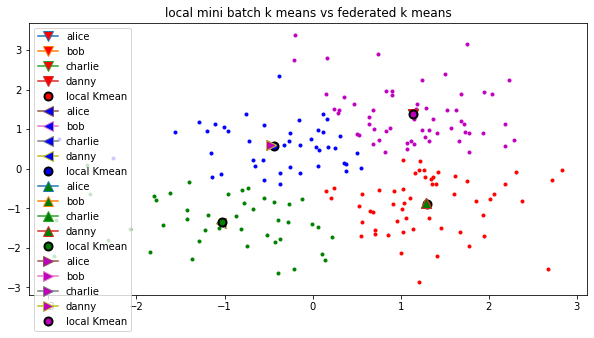

In [128]:
plt.figure(figsize=(10,5))
markers = ["v", "<", "^", ">"]
for cluster, col, m in zip(range(n_clusters), colors, markers):
    my_members = mbk_means_labels == cluster
    cluster_center = mbk_means_cluster_centers[cluster]
    plt.scatter(X[my_members, 0], X[my_members, 1], 
             marker='.', c=col)
    
    
    
    for i, n in enumerate(nodes.keys()):
        plt.plot(nodes[n]['model'].cluster_centers_[cluster,0],
                nodes[n]['model'].cluster_centers_[cluster,1],
                 marker=m,  label=str(n), ms=10, mew=1, markerfacecolor=col)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=8, mew=2,label="local Kmean")
    
    plt.title("local mini batch k means vs federated k means")
plt.legend()

In [100]:
nodes[n]['model'].cluster_centers_[c], nodes[n]['model'].cluster_centers_[order][c]

(array([-0.47456566,  0.60232668]), array([-0.47456566,  0.60232668]))

In [85]:
mbk_local.cluster_centers_, nodes[n]['model'].cluster_centers_

(array([[ 1.29478335, -0.89861653],
        [-0.43522969,  0.57844078],
        [-1.02891841, -1.33834747],
        [ 1.13579154,  1.38098617]]),
 array([[ 1.13843178,  1.38637337],
        [-1.03485369, -1.37325317],
        [ 1.28257918, -0.8805307 ],
        [-0.47456566,  0.60232668]]))

### Display plots of losses

Text(0.5, 0, 'epochs x rounds')

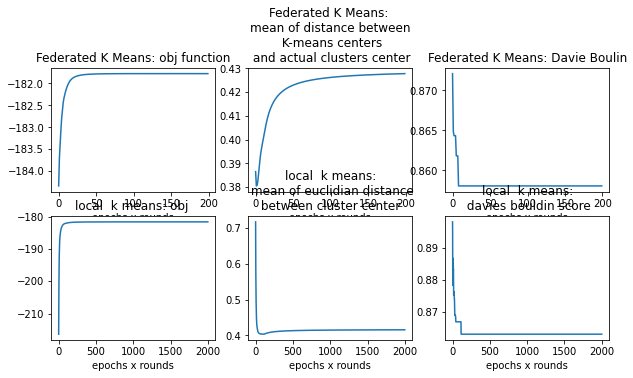

In [164]:
plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
plt.plot(history["obj"])
plt.xlabel("epochs x rounds")
plt.title("Federated K Means: obj function")

plt.subplot(2,3,2)
plt.plot(np.mean(np.array(history["euclidian"]), axis=1))
plt.title("Federated K Means: \nmean of distance between\n K-means centers\n and actual clusters center")
plt.xlabel("epochs x rounds")

plt.subplot(2,3,3)
plt.plot(history["db"])
plt.title("Federated K Means: Davie Boulin")
plt.xlabel("epochs x rounds")

plt.subplot(2,3, 4)
plt.title("local  k means: obj ")
plt.plot(history_local["obj"])
plt.xlabel("epochs x rounds")

plt.subplot(2,3,5)
plt.title("local  k means:\n mean of euclidian distance\n between cluster center ")
plt.plot(np.mean(history_local["euclidian"], axis=1))
plt.xlabel("epochs x rounds")


plt.subplot(2,3,6)

plt.title("local  k means:\n davies bouldin score")
plt.plot(history_local["db"])
plt.xlabel("epochs x rounds")

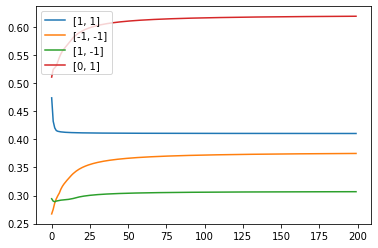

In [161]:
plt.plot(np.array(history["euclidian"]), label=cluster_centers)
plt.legend()

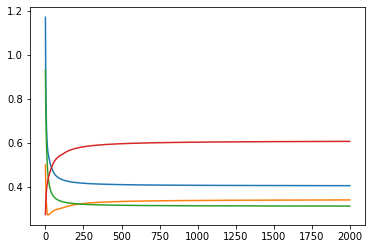

In [158]:
plt.plot(history_local["euclidian"])